# Calculate trends for individual CESM1-LE ensemble members

#### Jonah Shaw, 09/29/2021

Building functionality from cesmle_testbed.ipynb into a more compact form. Add optional mask.

### Do imports

In [1]:
import sys
# Add common resources folder to path
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/')
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/Common/') # is this good or not good. I should reorg.
# sys.path.append("/home/jonahks/git_repos/netcdf_analysis/Common/")

from imports import (
    pd, np, xr, mpl, plt, sns, os, 
    datetime, gridspec, ccrs, 
    Iterable, cmaps, glob, copy
    )

from functions import (
    masked_average, add_weights, leap_year,
    to_png, stats, MidpointNormalize, fix_cesm_time
    )

from collections import deque
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Define function for computing trends

#### New slower function that uses scipy.stats.linregress via apply_ufunc and gets info on statistical significance

In [2]:
def linregress2(x, y):
    # Wrapper around scipy linregress to use in apply_ufunc
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    return np.array([slope, intercept, r_value, p_value, std_err])

In [3]:
def vectorized_linregress2(data):
    '''
    Package for vectorized linregress call from: 
    https://stackoverflow.com/questions/52094320/with-xarray-how-to-parallelize-1d-operations-on-a-multidimensional-dataset. 
    Not very general.
    '''
    
    regressed_month = xr.apply_ufunc(
        linregress2, data['year'], data,
        input_core_dims=[['year'], ['year']],
        output_core_dims=[["parameter"]],
        vectorize=True,
        dask="parallelized",
        output_dtypes=['float64'],
        output_sizes={"parameter": 5},
                      )
    
    return regressed_month

In [4]:
def compute_trends_n_signif2(subset_data):
    '''
    Package the trend calculating lines to save space. V2 uses vectorized_linregress2
    '''
    # create empty arrays for needed output
    _trends = xr.zeros_like(subset_data.groupby('time.month').mean('time')).load()
    _rvalues = _trends.copy()
    _pvalues = _trends.copy()

    # Potentially I should be able to format this to avoid this for loop too
    for i,_month in subset_data.groupby('time.month'):
#         print(i,end='')

        _yearlydata = _month.groupby('time.year').mean('time').chunk({'year': -1}) # let the other dimensions chunk however?
        regressed_month = vectorized_linregress2(_yearlydata)

        ii = i-1 # the count starts at month 1 (January) but we need to index starting at 0
        
        _trends[ii] = regressed_month.isel(parameter=0)
        _rvalues[ii] = regressed_month.isel(parameter=2)
        _pvalues[ii] = regressed_month.isel(parameter=3)

    # Calculate statistical significance
    N = len(_yearlydata.year)
    dof=N-2

    tcrit=stats.t.ppf(0.975,dof)  ## two-sided 95%
    t=_rvalues*np.sqrt(N-2)/np.sqrt((1-_rvalues*_rvalues))

    _statsig=(1-_pvalues)*100
    _notnull = t > tcrit # disproving the null hypothesis (slope is zero)    
    
    return _trends,_statsig,_notnull

### Iterate over ensemble members and variables of interest

In [5]:
cesmle_path = '/glade/campaign/cesm/collections/cesmLE/CESM-CAM5-BGC-LE/atm/proc/tseries/monthly/'

In [6]:
model_variables = ['ICEFRAC','FLUT','FSNTOA','TS','LANDFRAC','TMQ']


In [7]:
# hardcoded alternate with only ensembles we can use
ensemble_nums2 = [
    '001', '002', '003', '004', '005', 
    '006', '007', '008', '009', '010',
    '011', '012', '013', '014', '015',
    '016', '017', '018', '019', '020',
    '021', '022', '023', '024', '025', 
    '026', '027', '028', '029', '030', 
    '031', '032', '033', '034', '035', 
    '101', '102', '103', '104', '105'
]

#### Collect all paths in a dictionary

In [8]:
path_dict = {} # first key is the ensemble number, second is the model variable

for _ensn in ensemble_nums2:
    for _var in model_variables:
        _t1_file = glob.glob('%s/%s/b.e11.B20TRC5CNBDRD.f09_g16.%s.cam.h0.%s.1??001-200512.nc' % (cesmle_path,_var,_ensn,_var))
        _t2_file = glob.glob('%s/%s/b.e11.BRCP85C5CNBDRD.f09_g16.%s.cam.h0.%s.200601-2???12.nc' % (cesmle_path,_var,_ensn,_var))

        if (len(_t1_file) != 1) or (len(_t2_file) != 1):
            print('glob returned ambiguous (or zero) file names for ensemble member %s' % _ensn)
            break
        try:
            path_dict[_ensn][_var]=[*_t1_file,*_t2_file]
        except:
            path_dict[_ensn] = {_var: [*_t1_file,*_t2_file]}    

__Functions I will need:__  

- Large wrapper for calculating trends and significance for a single variable of an ensemble member. Inputs: dictionary of paths for an single LENS member
- Function that takes paths to historical and rcp segments and returns a concatenated xarray corrected in time and subset by time (2001-2020) and lat-lon (>59N). Inputs: two paths. Returns: single xarray dataset object.
- Inner function that computes trends, stat_sig, and not_null and saves them to a specific path. Inputs: xr.dataset object, path to save dir. Returns: Error flag if issue.

In [9]:
def compute_trend(ds:xr.DataArray,
                  save_str,
                  save_dir,
                  mask=None):
    '''
    Takes an xarray object (dataset or dataarray?), variable name, path to save to, and mask. 
    Computes time trends over the mon-lat grid, as well as the statistical significance of those trends and saves them.
    '''
    
    _lon_avg = masked_average(ds,mask=mask,dim=['lon'])

    _trends,_statsig,_notnull = compute_trends_n_signif2(_lon_avg)    
    
    all_data = xr.merge([_trends.rename('TREND'),_statsig.rename('STATSIG'),_notnull.rename('NOTNULL')])
    
    print('%s/%s.2001_2020.nc' % (save_dir,save_str))
#     return all_data
    all_data.to_netcdf('%s/%s.2001_2020.nc' % (save_dir,save_str))    

In [10]:
def arc_subset(*paths,var):
    '''
    Takes paths to several GCM outputs that are adjacent in time. Concatentates files and then 
    - corrects CESM time coordinate
    - subsets for time period 2001-2020.
    - subsets for the Arctic (lat > 60N)
    
    return subsetted data
    '''

    _ds_i = xr.open_mfdataset(paths)
    subset = fix_cesm_time(_ds_i)[var].sel(time=slice('2001-01-01','2020-12-31'),lat=slice(59,None))
    
    return subset

In [11]:
def lens_trend_wrapper(sub_path_dict,ens_label,out_path,mask=None,mask_label=None):
    '''
    Takes a dictionary with variable names as keys and paths as values.
    Also takes a label for the output file and an optional mask.
    Uses the above functions to compute and save trends for each variable.
    '''
    
    for _var in sub_path_dict:
        _files = sub_path_dict[_var]

        _subset = arc_subset(*_files,var=_var)
        if _var == 'ICEFRAC':
            _subset = 100*_subset # correct units to percentage
            
        if mask:
            try:
                _label = '%s.%s.%s' % (_var,ens_label,mask_label)
            except:
                print('Must pass label for masked trends')
        else:
            _label = '%s.%s' % (_var,ens_label)
        _out = compute_trend(_subset,_label,out_path,mask=mask)
            
#         return _out
#         break
            

In [129]:
# %%time

# lens_trend_wrapper(path_dict['002'],'002','/glade/work/jonahshaw/LENS/CESM1-LE/ArcticMemberTrends/')

/glade/work/jonahshaw/LENS/CESM1-LE/ArcticMemberTrends//ICEFRAC.002.2001_2020.nc
/glade/work/jonahshaw/LENS/CESM1-LE/ArcticMemberTrends//FLUT.002.2001_2020.nc
/glade/work/jonahshaw/LENS/CESM1-LE/ArcticMemberTrends//FSNTOA.002.2001_2020.nc
/glade/work/jonahshaw/LENS/CESM1-LE/ArcticMemberTrends//TS.002.2001_2020.nc
/glade/work/jonahshaw/LENS/CESM1-LE/ArcticMemberTrends//LANDFRAC.002.2001_2020.nc
CPU times: user 27.4 s, sys: 1.65 s, total: 29 s
Wall time: 33 s


In [13]:
# for _ens_n in path_dict:
#     print(_ens_n)
#     lens_trend_wrapper(path_dict[_ens_n],_ens_n,'/glade/work/jonahshaw/LENS/CESM1-LE/ArcticMemberTrends/')

001
/glade/work/jonahshaw/LENS/CESM1-LE/ArcticMemberTrends//TMQ.001.2001_2020.nc
002
/glade/work/jonahshaw/LENS/CESM1-LE/ArcticMemberTrends//TMQ.002.2001_2020.nc
003
/glade/work/jonahshaw/LENS/CESM1-LE/ArcticMemberTrends//TMQ.003.2001_2020.nc
004
/glade/work/jonahshaw/LENS/CESM1-LE/ArcticMemberTrends//TMQ.004.2001_2020.nc
005
/glade/work/jonahshaw/LENS/CESM1-LE/ArcticMemberTrends//TMQ.005.2001_2020.nc
006
/glade/work/jonahshaw/LENS/CESM1-LE/ArcticMemberTrends//TMQ.006.2001_2020.nc
007
/glade/work/jonahshaw/LENS/CESM1-LE/ArcticMemberTrends//TMQ.007.2001_2020.nc
008
/glade/work/jonahshaw/LENS/CESM1-LE/ArcticMemberTrends//TMQ.008.2001_2020.nc
009
/glade/work/jonahshaw/LENS/CESM1-LE/ArcticMemberTrends//TMQ.009.2001_2020.nc
010
/glade/work/jonahshaw/LENS/CESM1-LE/ArcticMemberTrends//TMQ.010.2001_2020.nc
011
/glade/work/jonahshaw/LENS/CESM1-LE/ArcticMemberTrends//TMQ.011.2001_2020.nc
012
/glade/work/jonahshaw/LENS/CESM1-LE/ArcticMemberTrends//TMQ.012.2001_2020.nc
013
/glade/work/jonahshaw/LE

In [8]:
def LEplot_arctrends(ens_n,path,key=None):
    
    if key:
        print('not implemented you silly')
    else:
        _olr = xr.open_dataset('%s/FLUT.%s.2001_2020.nc' % (path,ens_n))
        _asr = xr.open_dataset('%s/FSNTOA.%s.2001_2020.nc' % (path,ens_n))
        _icefrac = xr.open_dataset('%s/ICEFRAC.%s.2001_2020.nc' % (path,ens_n))
        _ts = xr.open_dataset('%s/TS.%s.2001_2020.nc' % (path,ens_n))
        _tmq = xr.open_dataset('%s/TMQ.%s.2001_2020.nc' % (path,ens_n))
        
    ts_trends_wrapped = xr.concat([_ts['TREND'],_ts['TREND'][0].assign_coords({'month':13})],dim='month')
    ts_statsig_wrapped = xr.concat([_ts['STATSIG'],_ts['STATSIG'][0].assign_coords({'month':13})],dim='month')

    seaice_trends_wrapped = xr.concat([_icefrac['TREND'],_icefrac['TREND'][0].assign_coords({'month':13})],dim='month')
    seaice_statsig_wrapped = xr.concat([_icefrac['STATSIG'],_icefrac['STATSIG'][0].assign_coords({'month':13})],dim='month')

    asr_trends_wrapped = xr.concat([_asr['TREND'],_asr['TREND'][0].assign_coords({'month':13})],dim='month')
    asr_statsig_wrapped = xr.concat([_asr['STATSIG'],_asr['STATSIG'][0].assign_coords({'month':13})],dim='month')

    olr_trends_wrapped = xr.concat([_olr['TREND'],_olr['TREND'][0].assign_coords({'month':13})],dim='month')
    olr_statsig_wrapped = xr.concat([_olr['STATSIG'],_olr['STATSIG'][0].assign_coords({'month':13})],dim='month')
    
    tmq_trends_wrapped = xr.concat([_tmq['TREND'],_tmq['TREND'][0].assign_coords({'month':13})],dim='month')
    tmq_statsig_wrapped = xr.concat([_tmq['STATSIG'],_tmq['STATSIG'][0].assign_coords({'month':13})],dim='month')
    
    fig1,axs = plt.subplots(nrows=2,ncols=3,figsize=(23,15))

    axes = axs.flat

    ytick_labels = np.array([60,65,70,75,80,90])
    yticks = np.sin(np.pi*ytick_labels/180)

    xtick_labels = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
    xticks = np.arange(1,13.01,1)

    palette = sns.diverging_palette(257, 10, s=99, l=44, sep=50, n=8, as_cmap=True)
    
    # Set axis ticks accounting for area weighting
    for _ax in axes:
        _ax.set_ylim(np.sin(np.pi/3),1)
        _ax.set_yticks(yticks)
        _ax.set_yticklabels(ytick_labels)
        _ax.set_xticks(xticks)
        _ax.set_xticklabels(xtick_labels)
        
    lat_weighted0 = np.sin(np.pi/180*seaice_trends_wrapped['lat'])
    cmap0 = copy.copy(palette)
    im0 = axes[0].contourf(seaice_trends_wrapped['month'],lat_weighted0,seaice_trends_wrapped.transpose('lat','month'),
                           cmap=cmap0,extend='both',levels=np.arange(-1.4,0.61,0.4),vmin=-1.4,vmax=1.4)
    im0.cmap.set_over((0.9,0.44,0.44))
    stip = axes[0].contourf(seaice_statsig_wrapped['month'],lat_weighted0,seaice_statsig_wrapped.transpose('lat','month'), colors='none',levels=[0,99,100],
                            hatches=[None,'//'],extend='neither')
    axes[0].set_title('Sea Ice concentration',fontsize=14)
    plt.colorbar(im0,ax=axes[0],label='%/yr')
    
    lat_weighted1 = np.sin(np.pi/180*ts_trends_wrapped['lat'])
    cmap1 = copy.copy(palette)
    im1 = axes[1].contourf(ts_trends_wrapped['month'],lat_weighted1,ts_trends_wrapped.transpose('lat','month'),
                           cmap=cmap1,extend='both',levels=np.arange(-0.15,0.451,0.1),vmin=-0.45,vmax=0.45)
    im1.cmap.set_under((0.6,0.72,0.89))
    stip = axes[1].contourf(ts_statsig_wrapped['month'],lat_weighted1,ts_statsig_wrapped.transpose('lat','month'), colors='none',levels=[0,99,100],
                            hatches=[None,'//'],extend='neither')
    axes[1].set_title('CESM1 Surface Temperature Trends',fontsize=14)
    cbar = plt.colorbar(im1,ax=axes[1],label='K/yr')
    
    lat_weighted2 = np.sin(np.pi/180*tmq_trends_wrapped['lat'])
    im2 = axes[2].contourf(tmq_trends_wrapped['month'],lat_weighted2,tmq_trends_wrapped.transpose('lat','month'), # -0.15,0.45
                           cmap=palette,norm=mpl.colors.TwoSlopeNorm(vmin=-0.06, vcenter=0., vmax=0.14),extend='both',levels=np.arange(-0.06,0.141,0.04))
    stip = axes[2].contourf(tmq_statsig_wrapped['month'],lat_weighted2,tmq_statsig_wrapped.transpose('lat','month'), colors='none',levels=[0,99,100],
                            hatches=[None,'//'],extend='neither')
    axes[2].set_title('CESM1 Precipitable Water Vapor Trends',fontsize=14)
    cbar = plt.colorbar(im2,ax=axes[2],label='K/yr')

    lat_weighted3 = np.sin(np.pi/180*asr_trends_wrapped['lat'])
    cmap3 = copy.copy(palette)
    im3 = axes[3].contourf(asr_trends_wrapped['month'],lat_weighted3,asr_trends_wrapped.transpose('lat','month'),
                           cmap=cmap3,extend='both',levels=np.arange(-0.9,2.11,0.6),vmin=-3.0,vmax=3.0)
    im3.cmap.set_under((0.6,0.72,0.89))
    stip = axes[3].contourf(asr_statsig_wrapped['month'],lat_weighted3,asr_statsig_wrapped.transpose('lat','month'), colors='none',levels=[0,99,100],
                            hatches=[None,'//'],extend='neither')
    axes[3].set_title('CERES ASR Trend',fontsize=14)
    plt.colorbar(im3,ax=axes[3],label='Wm$^{-2}$yr$^{-1}$')

    lat_weighted4 = np.sin(np.pi/180*olr_trends_wrapped['lat'])
    cmap4 = copy.copy(palette)
    im4 = axes[4].contourf(olr_trends_wrapped['month'],lat_weighted4,olr_trends_wrapped.transpose('lat','month'),
                           cmap=cmap4,extend='both',levels=np.arange(-0.3,0.7,0.2),vmin=-0.7,vmax=0.7)
    im4.cmap.set_under((0.51,0.66,0.9))
    stip = axes[4].contourf(olr_statsig_wrapped['month'],lat_weighted4,olr_statsig_wrapped.transpose('lat','month'), colors='none',levels=[0,99,100],
                            hatches=[None,'//'],extend='neither')
    axes[4].set_title('CERES OLR Trends',fontsize=14)
    plt.colorbar(im4,ax=axes[4],label='Wm$^{-2}$yr$^{-1}$')

    fig1.suptitle('Arctic Trends in CESM1-LE Member %s' % ens_n,fontsize=30,y=0.95)
    
    return fig1, cbar

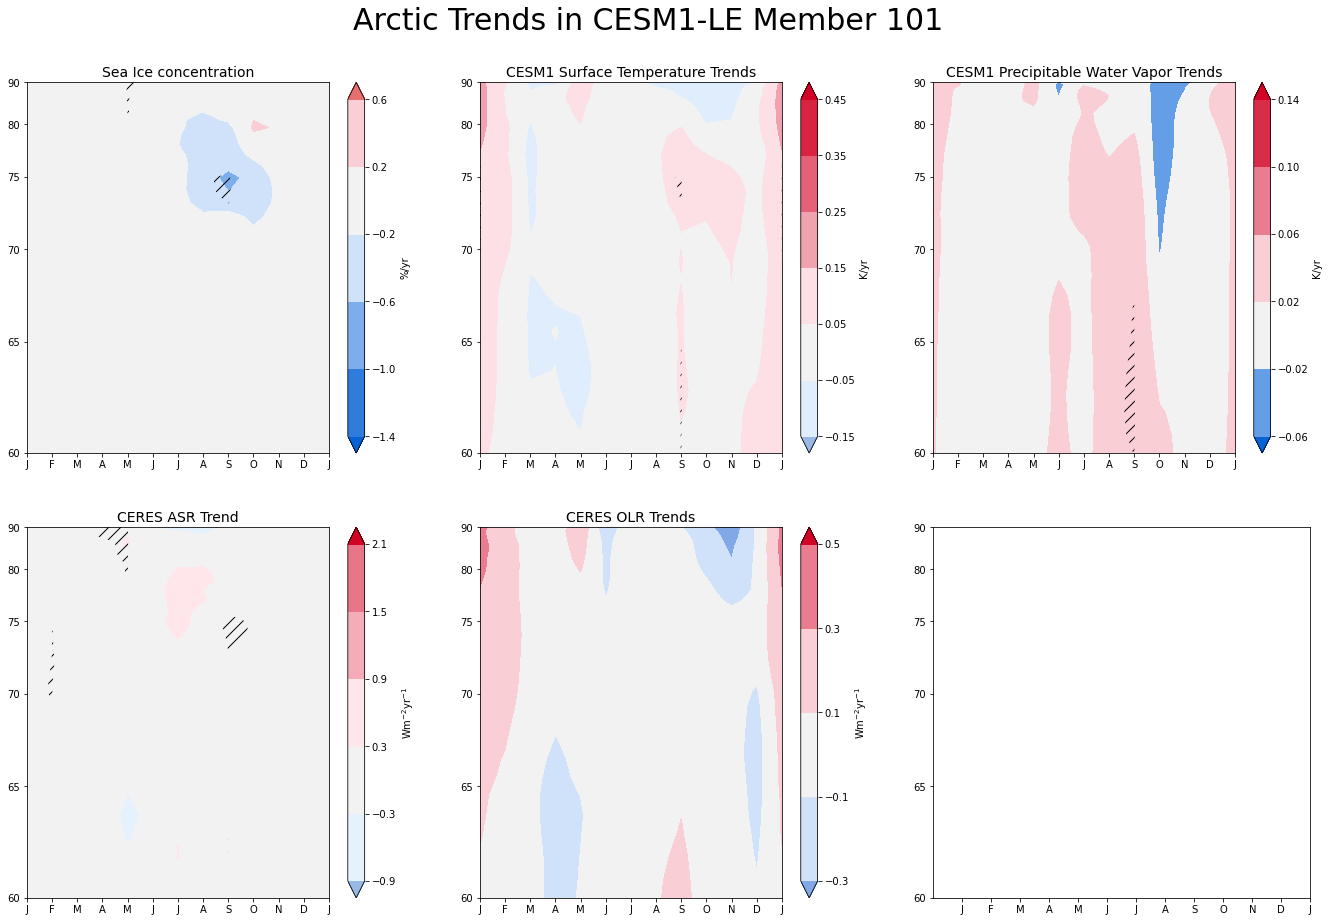

In [12]:
_fig,_cbar = LEplot_arctrends('101','/glade/work/jonahshaw/LENS/CESM1-LE/ArcticMemberTrends/')

In [15]:
def LEplot_arctrends_4panel(ens_n,path,key=None):
    
    if key:
        print('not implemented you silly')
    else:
        _olr = xr.open_dataset('%s/FLUT.%s.2001_2020.nc' % (path,ens_n))
        _asr = xr.open_dataset('%s/FSNTOA.%s.2001_2020.nc' % (path,ens_n))
        _icefrac = xr.open_dataset('%s/ICEFRAC.%s.2001_2020.nc' % (path,ens_n))
        _ts = xr.open_dataset('%s/TS.%s.2001_2020.nc' % (path,ens_n))
        _tmq = xr.open_dataset('%s/TMQ.%s.2001_2020.nc' % (path,ens_n))
        
    ts_trends_wrapped = xr.concat([_ts['TREND'],_ts['TREND'][0].assign_coords({'month':13})],dim='month')
    ts_statsig_wrapped = xr.concat([_ts['STATSIG'],_ts['STATSIG'][0].assign_coords({'month':13})],dim='month')

    seaice_trends_wrapped = xr.concat([_icefrac['TREND'],_icefrac['TREND'][0].assign_coords({'month':13})],dim='month')
    seaice_statsig_wrapped = xr.concat([_icefrac['STATSIG'],_icefrac['STATSIG'][0].assign_coords({'month':13})],dim='month')

    asr_trends_wrapped = xr.concat([_asr['TREND'],_asr['TREND'][0].assign_coords({'month':13})],dim='month')
    asr_statsig_wrapped = xr.concat([_asr['STATSIG'],_asr['STATSIG'][0].assign_coords({'month':13})],dim='month')

    olr_trends_wrapped = xr.concat([_olr['TREND'],_olr['TREND'][0].assign_coords({'month':13})],dim='month')
    olr_statsig_wrapped = xr.concat([_olr['STATSIG'],_olr['STATSIG'][0].assign_coords({'month':13})],dim='month')
    
#     tmq_trends_wrapped = xr.concat([_tmq['TREND'],_tmq['TREND'][0].assign_coords({'month':13})],dim='month')
#     tmq_statsig_wrapped = xr.concat([_tmq['STATSIG'],_tmq['STATSIG'][0].assign_coords({'month':13})],dim='month')
    
    fig1,axs = plt.subplots(nrows=2,ncols=2,figsize=(18,15))

    axes = axs.flat

    ytick_labels = np.array([60,65,70,75,80,90])
    yticks = np.sin(np.pi*ytick_labels/180)

    xtick_labels = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
    xticks = np.arange(1,13.01,1)

    palette = sns.diverging_palette(257, 10, s=99, l=44, sep=50, n=5, as_cmap=True)
    
    # Set axis ticks accounting for area weighting
    for _ax in axes:
        _ax.set_ylim(np.sin(np.pi/3),1)
        _ax.set_yticks(yticks)
        _ax.set_yticklabels(ytick_labels)
        _ax.set_xticks(xticks)
        _ax.set_xticklabels(xtick_labels)
        
    lat_weighted0 = np.sin(np.pi/180*seaice_trends_wrapped['lat'])
    cmap0 = copy.copy(palette)
    im0 = axes[0].contourf(seaice_trends_wrapped['month'],lat_weighted0,seaice_trends_wrapped.transpose('lat','month'),
                           cmap=cmap0,extend='both',levels=np.arange(-1.4,0.61,0.4),vmin=-1.4,vmax=1.4)
    im0.cmap.set_over((0.9,0.44,0.44))
    stip = axes[0].contourf(seaice_statsig_wrapped['month'],lat_weighted0,seaice_statsig_wrapped.transpose('lat','month'), colors='none',levels=[0,99,100],
                            hatches=[None,'//'],extend='neither')
    axes[0].set_title('Sea Ice concentration',fontsize=14)
    plt.colorbar(im0,ax=axes[0],label='%/yr')
    
    lat_weighted1 = np.sin(np.pi/180*ts_trends_wrapped['lat'])
    cmap1 = copy.copy(palette)
    im1 = axes[1].contourf(ts_trends_wrapped['month'],lat_weighted1,ts_trends_wrapped.transpose('lat','month'),
                           cmap=cmap1,extend='both',levels=np.arange(-0.15,0.451,0.1),vmin=-0.45,vmax=0.45)
    im1.cmap.set_under((0.6,0.72,0.89))
    stip = axes[1].contourf(ts_statsig_wrapped['month'],lat_weighted1,ts_statsig_wrapped.transpose('lat','month'), colors='none',levels=[0,99,100],
                            hatches=[None,'//'],extend='neither')
    axes[1].set_title('CESM1 Surface Temperature Trends',fontsize=14)
    cbar = plt.colorbar(im1,ax=axes[1],label='K/yr')

    lat_weighted2 = np.sin(np.pi/180*asr_trends_wrapped['lat'])
    cmap2 = copy.copy(palette)
    im2 = axes[2].contourf(asr_trends_wrapped['month'],lat_weighted2,asr_trends_wrapped.transpose('lat','month'),
                           cmap=cmap2,extend='both',levels=np.arange(-0.9,2.11,0.6),vmin=-3.0,vmax=3.0)
    im2.cmap.set_under((0.6,0.72,0.89))
    stip = axes[2].contourf(asr_statsig_wrapped['month'],lat_weighted2,asr_statsig_wrapped.transpose('lat','month'), colors='none',levels=[0,99,100],
                            hatches=[None,'//'],extend='neither')
    axes[2].set_title('CERES ASR Trend',fontsize=14)
    plt.colorbar(im2,ax=axes[2],label='Wm$^{-2}$yr$^{-1}$')

    lat_weighted3 = np.sin(np.pi/180*olr_trends_wrapped['lat'])
    cmap3 = copy.copy(palette)
    im3 = axes[3].contourf(olr_trends_wrapped['month'],lat_weighted3,olr_trends_wrapped.transpose('lat','month'),
                           cmap=cmap3,extend='both',levels=np.arange(-0.3,0.7,0.2),vmin=-0.7,vmax=0.7)
    im3.cmap.set_under((0.51,0.66,0.9))
    stip = axes[3].contourf(olr_statsig_wrapped['month'],lat_weighted3,olr_statsig_wrapped.transpose('lat','month'), colors='none',levels=[0,99,100],
                            hatches=[None,'//'],extend='neither')
    axes[3].set_title('CERES OLR Trends',fontsize=14)
    plt.colorbar(im3,ax=axes[3],label='Wm$^{-2}$yr$^{-1}$')

    fig1.suptitle('Arctic Trends in CESM1-LE Member %s' % ens_n,fontsize=30,y=0.95)
    
    return fig1, cbar

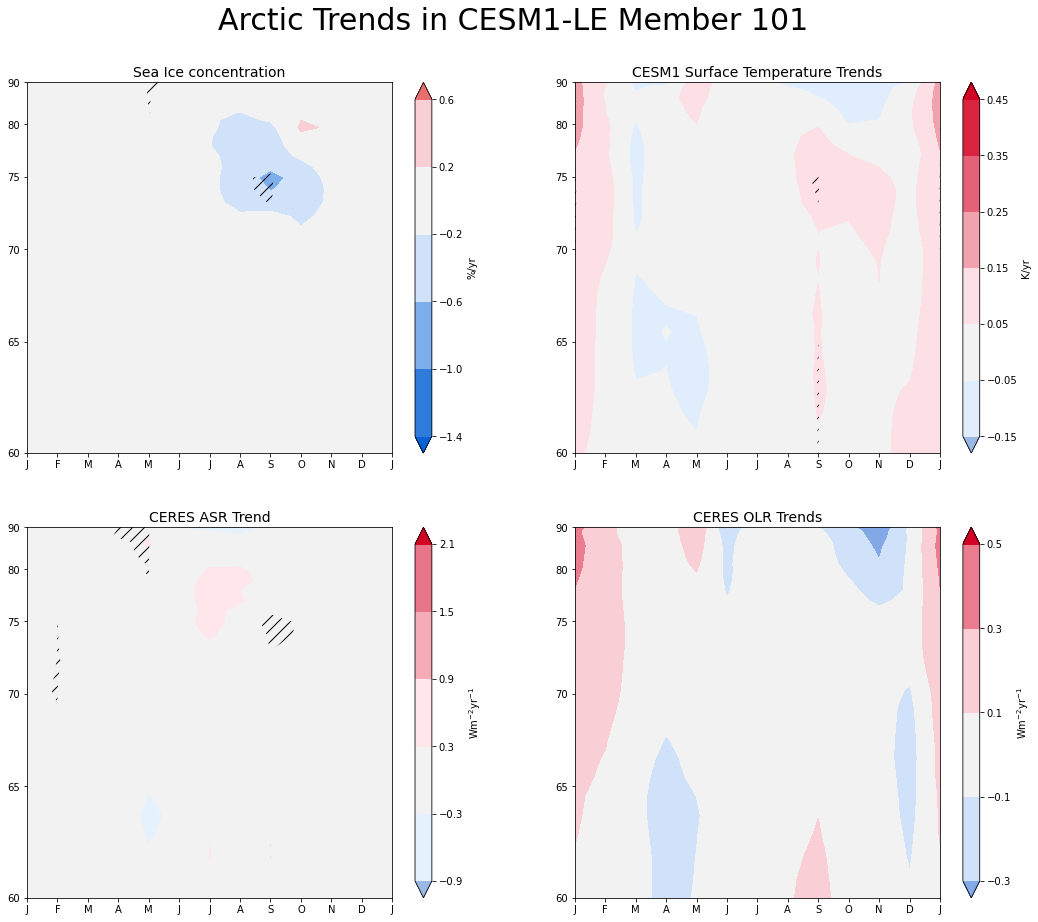

In [21]:
_fig,_cbar = LEplot_arctrends_4panel('101','/glade/work/jonahshaw/LENS/CESM1-LE/ArcticMemberTrends/')

In [22]:
to_png(_fig,'CESM2_4paneltrends_member101')

(<Figure size 1080x1080 with 8 Axes>,
 <matplotlib.colorbar.Colorbar at 0x2ad8b1edb250>)

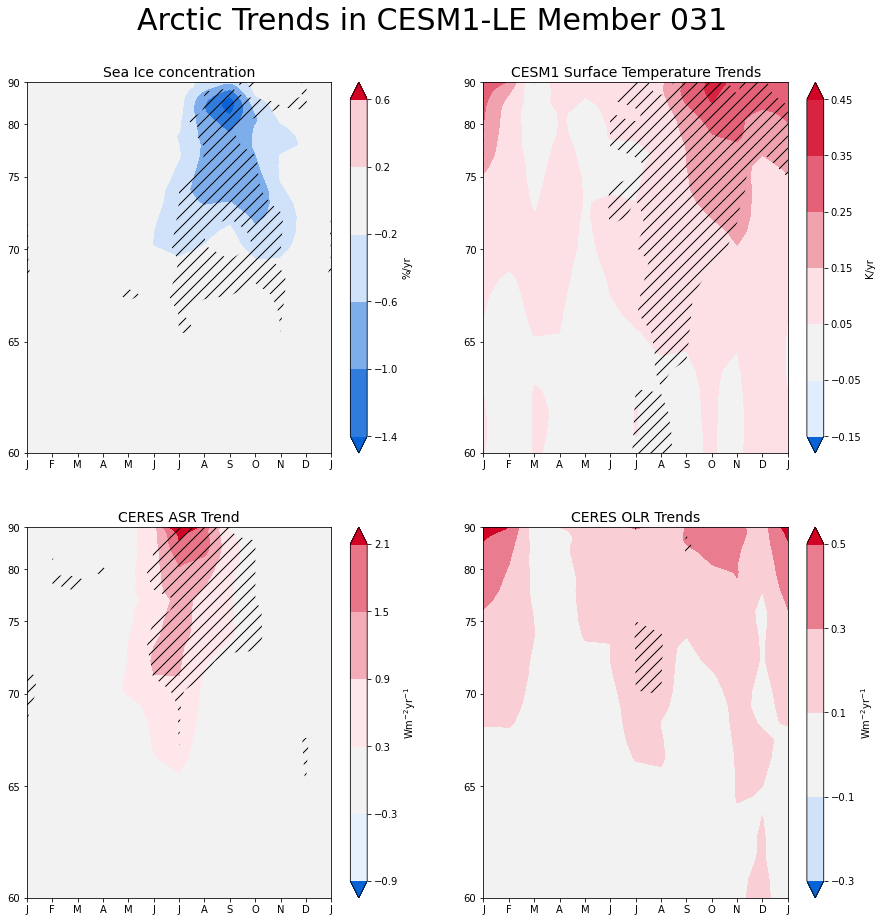

In [132]:
LEplot_arctrends('031','/glade/work/jonahshaw/LENS/CESM1-LE/ArcticMemberTrends/')

In [114]:
test = lens_trend_wrapper(path_dict['001'],'001','/glade/work/jonahshaw/LENS/CESM1-LE/ArcticMemberTrends/')

/glade/work/jonahshaw/LENS/CESM1-LE/ArcticMemberTrends//ICEFRAC.001.2001_2020.nc
